In [ ]:

from jax import config

config.update("jax_enable_x64", True)


Here, we consider the wavenumber-direction stitching of the cross section. We define a wavenumber grid of length \(2N\) before stitching, as well as two wavenumber grids of length \(N\) each, obtained by splitting the original grid. Can the cross sections be computed separately on these subdivided wavenumber grids and then combined?

In [2]:
from exojax.utils.grids import wavenumber_grid
from exojax.test.emulate_mdb import mock_mdb

mdb = mock_mdb("exomol")
N = 10000
nu_grid, _, _ = wavenumber_grid(4325.0, 4365.0, 2*N, xsmode="premodit")

nu_grid_left = nu_grid[0:N]
nu_grid_right = nu_grid[N:]

ModuleNotFoundError: No module named 'exojax'

We will calculate the cross sections for each of these three types of wavenumber grids using PreMODIT.

In [3]:
from exojax.spec.opacalc import OpaPremodit

T=1000.0 #K
P=1.0 #bar

opa_close_right = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_right,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="close",
)
xsv_close_right = opa_close_right.xsvector(T,P)

opa_close_left = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_left,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="close",
)
xsv_close_left = opa_close_left.xsvector(T,P)


opa_close_all = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="close",
)
xsv_close_all= opa_close_all.xsvector(T,P)



/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K


/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 18978.75it/s]

Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|###############-----| 75%

Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.


/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 7958.83it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.


/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 4937.38it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the closed mode. The aliasing part cannnot be used.


The cross sections computed after wavenumber splitting do not fully match those computed without splitting, particularly around the splitting points and near the endpoints. This discrepancy arises from the following reasons.  

In the default cross-section calculation of PreMODIT and MODIT, the Voigt profile convolution is performed using FFT. To eliminate aliasing effects, a buffer region of the same size as the computational domain is allocated, storing aliasing contributions from both sides. Since this buffer region is unnecessary for an individual wavenumber grid, it does not appear in the output. This calculation mode is referred to as the "closed aliasing mode."  

However, profile leakage from outside the wavenumber grid cannot be accounted for. As a result, around the splitting points, mutual leakage between the left and right wavenumber grids is ignored, leading to discrepancies in the computed cross sections at these points. Additionally, the mismatch near the endpoints occurs because the default assumption is that the Voigt profile's influence extends over a region equal to the size of one side of the wavenumber grid. Consequently, when the lengths of the wavenumber grids differ, slight discrepancies arise in the tail regions of the computed cross sections.

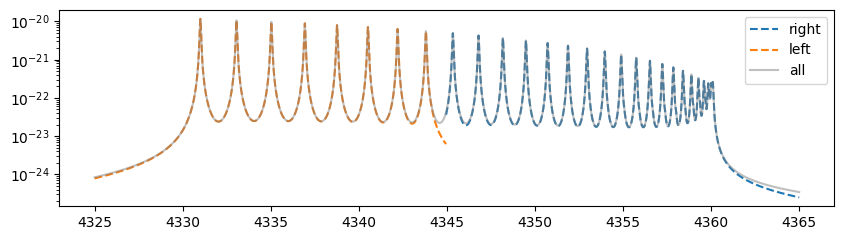

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 2.55))
plt.plot(nu_grid_right, xsv_close_right, ls="--", label="right")
plt.plot(nu_grid_left, xsv_close_left, ls="--", label="left")
plt.plot(nu_grid, xsv_close_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.legend()
plt.show()

The solution is to compute the aliasing region beyond the boundaries of the wavenumber domain and then sum the overlapping regions from different wavenumber domains afterward. This approach corresponds to the overlap-and-add (OLA) method.  

To achieve this, the convolution must be computed in an open manner by including buffer regions on both sides of the wavenumber domain. PreMODIT/MODIT supports this approach through the **open aliasing mode**, which can be enabled by setting `alias="open"`. Additionally, the extent of the Voigt profile beyond one side of the wavenumber domain can be specified using the `cutwing` parameter.

In [5]:
opa_open_right = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_right,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="open",
    cutwing=1.0,
)
xsv_open_right = opa_open_right.xsvector(T,P)

opa_open_left = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid_left,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="open",
    cutwing=1.0,
)
xsv_open_left = opa_open_left.xsvector(T,P)

opa_open_all = OpaPremodit(
    mdb=mdb,
    nu_grid=nu_grid,
    dit_grid_resolution=0.2,
    auto_trange=[400.0, 1500.0],
    alias="open",
    cutwing=0.5,
)
xsv_open_all= opa_open_all.xsvector(T,P)

/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 13168.93it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.


/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:280: UserWarning: Some of the line centers are outside of the wavenumber grid.
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/initspec.py:282: UserWarning: All of the line center should be within wavenumber grid for PreMODIT/MODIT/DIT.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 2548.18it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.


/home/kawahara/exojax/src/exojax/spec/opacalc.py:269: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 393.5569458240504 - 1647.2060977798956 K
OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 2/2 [00:00<00:00, 6052.39it/s]


Premodit: Twt= 457.65619999186345 K Tref= 1108.1485374361412 K
Making LSD:|####################| 100%
cross section (xsvector/xsmatrix) is calculated in the open mode. The aliasing part can be used.


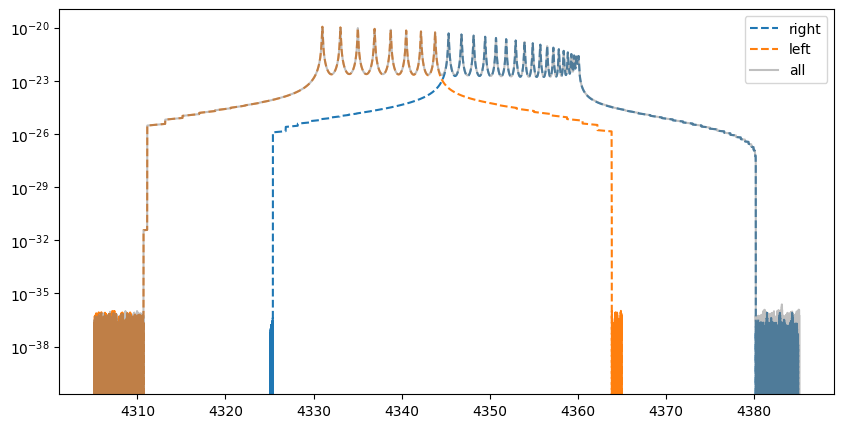

In [6]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
plt.plot(opa_open_right.nu_grid_extended, xsv_open_right, ls="--", label="right")
plt.plot(opa_open_left.nu_grid_extended, xsv_open_left, ls="--", label="left")
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.legend()
plt.show()

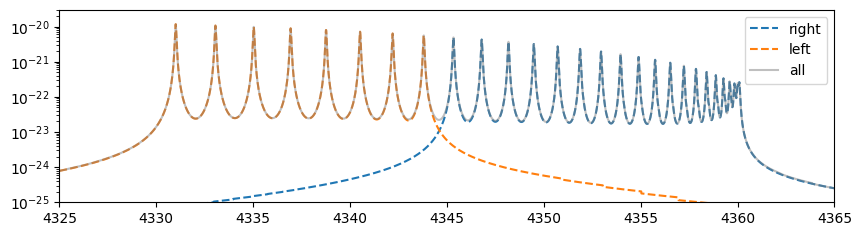

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
plt.plot(opa_open_right.nu_grid_extended, xsv_open_right, ls="--", label="right")
plt.plot(opa_open_left.nu_grid_extended, xsv_open_left, ls="--", label="left")
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.ylim(1.0e-25,3.0e-20)
plt.legend()
plt.show()

After performing the stitching, it is confirmed that the computed results closely match those obtained in the original wavenumber domain.

In [8]:
xsv_open_stitch = xsv_open_left[N:3*N]+xsv_open_right[0:2*N]

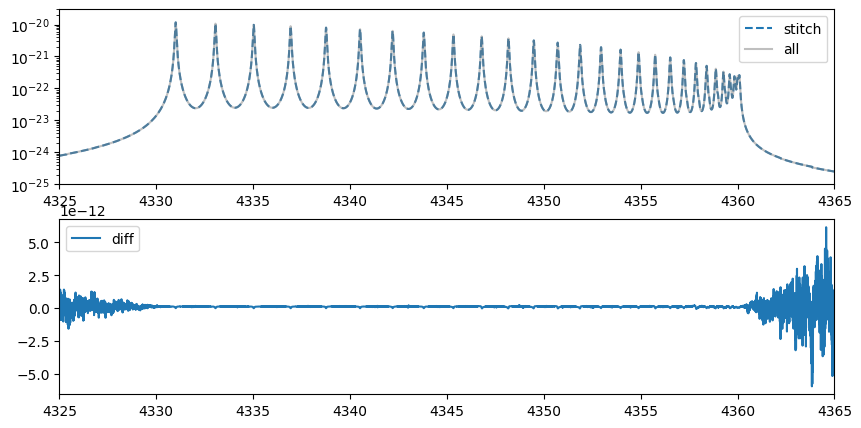

In [16]:



import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(211)
plt.plot(nu_grid, xsv_open_stitch, color="C0", ls="dashed", label="stitch")
plt.plot(nu_grid, xsv_open_all[N:3*N],alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.ylim(1.0e-25,3.0e-20)
plt.legend()
ax = fig.add_subplot(212)
plt.plot(nu_grid, xsv_open_all[N:3*N]/xsv_open_stitch -1.0, color="C0", label="diff")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.legend()
plt.show()

In [26]:
import jax.numpy as jnp
import jax
import jax.numpy as jnp

def overlap_add_scan(arrays, N):
    """
    """
    M, L = arrays.shape  
    out_len = N * (M + 2)

    def body(carry, vals):
        i, arr = vals
        offset = i * N
        current = jax.lax.dynamic_slice(carry, (offset,), (L,))
        updated = current + arr
        carry = jax.lax.dynamic_update_slice(carry, updated, (offset,))
        return carry, None  


    init = jnp.zeros(out_len)
    indices = jnp.arange(M)
    result, _ = jax.lax.scan(body, init, (indices, arrays))
    return result

xsv_matrix = jnp.vstack([xsv_open_left,xsv_open_right])
xsv_scan_stitch = overlap_add_scan(xsv_matrix, N)



In [30]:
opa_open_all.nu_grid_extended.shape, xsv_scan_stitch.shape

((40000,), (40000,))

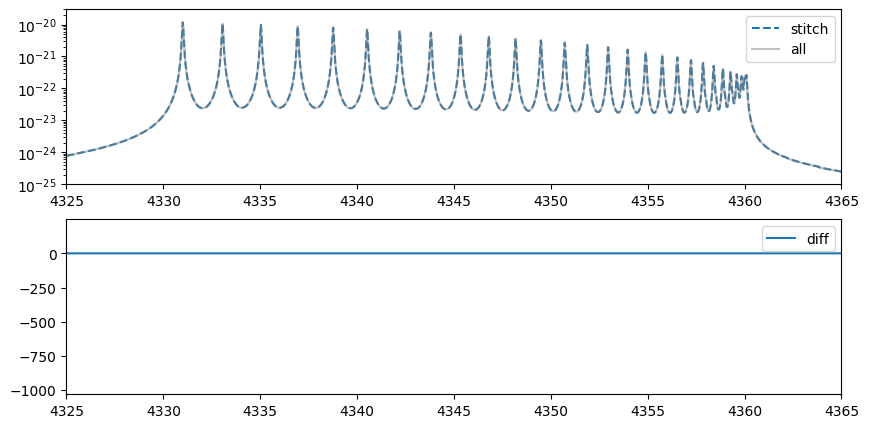

In [32]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(211)
plt.plot(opa_open_all.nu_grid_extended, xsv_scan_stitch, color="C0", ls="dashed", label="stitch")
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all,alpha=0.5, color="gray", label="all")
plt.yscale("log")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.ylim(1.0e-25,3.0e-20)
plt.legend()
ax = fig.add_subplot(212)
plt.plot(opa_open_all.nu_grid_extended, xsv_open_all/xsv_scan_stitch -1.0, color="C0", label="diff")
plt.xlim(nu_grid[0],nu_grid[-1])
plt.legend()
plt.show()